In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import binom
from scipy.optimize import minimize

# Part 1

In [3]:
data = pd.read_csv("C:/Users/difra/Desktop/cognitive/hw3data.txt", sep = "  ", header= None, engine='python')

## Visualizing data

In [4]:
means = data.mean(axis = 1) #means of the 20 samples for each stimulus
std = data.std(axis=1)

In [5]:
data["position"] = [(1,0), (2,0), (0,1), (0,2), (1,1), (1,2), (2,1), (2,2)]
data["S_a"] = [0, 30, np.NaN, np.NaN, 0, 0, 30, 30]
data["S_v"] = [np.NaN, np.NaN,0, 30, 0, 30, 0, 30]
data

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,position,S_a,S_v
0,9.0,-11.0,9.0,4.0,22.0,-11.0,1.0,5.0,4.0,-10.0,...,5.0,20.0,-6.0,-11.0,28.0,-22.0,10.0,"(1, 0)",0.0,NaN
1,24.0,35.0,21.0,15.0,34.0,43.0,17.0,24.0,27.0,45.0,...,30.0,17.0,29.0,16.0,31.0,28.0,20.0,"(2, 0)",30.0,NaN
2,-2.0,2.0,-2.0,-3.0,6.0,2.0,-3.0,1.0,4.0,5.0,...,1.0,-2.0,-3.0,3.0,-1.0,-3.0,-3.0,"(0, 1)",NaN,0.0
3,28.0,26.0,33.0,33.0,28.0,32.0,26.0,30.0,32.0,26.0,...,27.0,30.0,30.0,32.0,26.0,26.0,22.0,"(0, 2)",NaN,30.0
4,-7.0,4.0,4.0,-2.0,-1.0,-6.0,-6.0,1.0,-6.0,1.0,...,1.0,9.0,-4.0,8.0,-3.0,-6.0,5.0,"(1, 1)",0.0,0.0
5,25.0,24.0,27.0,33.0,29.0,24.0,27.0,27.0,31.0,22.0,...,22.0,28.0,25.0,25.0,27.0,23.0,30.0,"(1, 2)",0.0,30.0
6,2.0,-2.0,6.0,6.0,8.0,2.0,5.0,5.0,5.0,4.0,...,4.0,4.0,5.0,6.0,5.0,3.0,-4.0,"(2, 1)",30.0,0.0
7,31.0,28.0,32.0,33.0,32.0,28.0,32.0,29.0,27.0,32.0,...,32.0,34.0,25.0,29.0,12.0,32.0,27.0,"(2, 2)",30.0,30.0


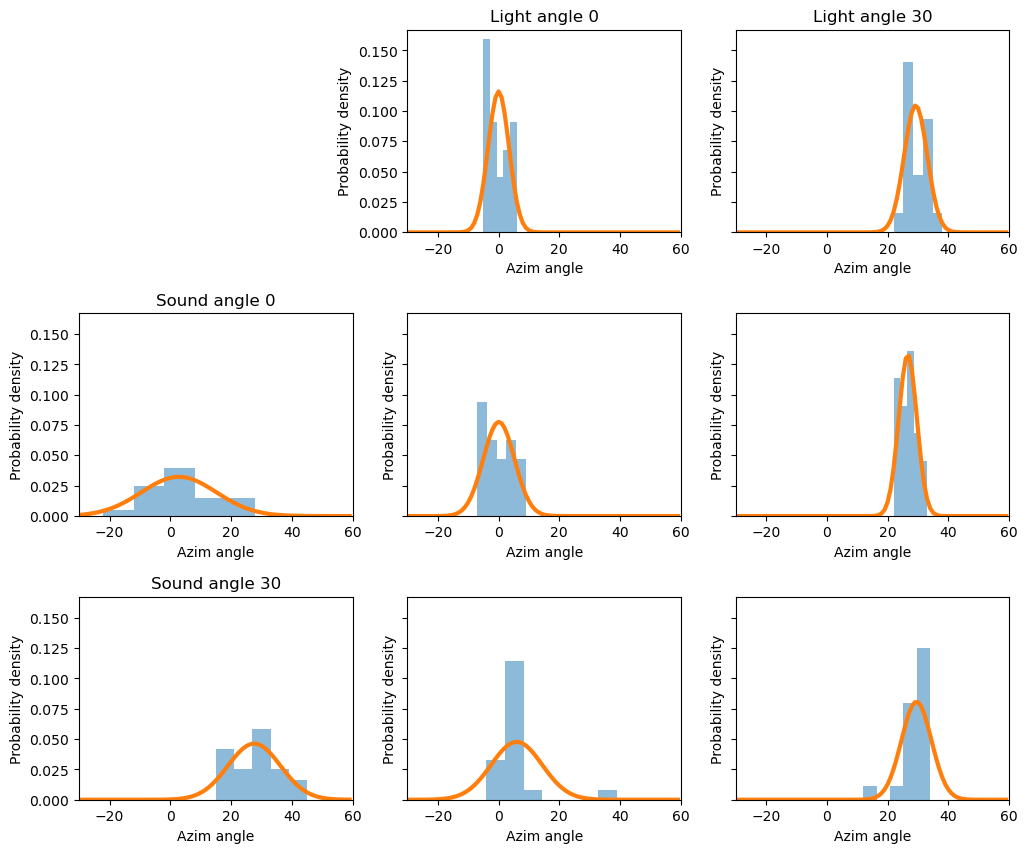

In [6]:
fig, axs = plt.subplots(3, 3, figsize = (12, 10), sharey = True)

x_axis = np.arange(-30, 60)
bins = [5, 5, 5, 5, 5, 5, 7, 5]

for i in range(8):
  (a, b) = data.iloc[i,-3] #take the position column value for the row i 
  axs[a, b].hist(data.iloc[i,:20], density=True, bins=bins[i], alpha=0.5) #take all the data for the row i
  axs[a, b].plot(x_axis, norm.pdf(x_axis, means[i], std[i]), linewidth=3)

for i in range(3):
  for j in range(3):
    axs[i, j].set_xlim([-30,60])
    axs[i, j].set_xlabel("Azim angle")
    axs[i, j].set_ylabel("Probability density") 

axs[0,1].set_title("Light angle 0")
axs[0,2].set_title("Light angle 30")

axs[1,0].set_title("Sound angle 0")
axs[2,0].set_title("Sound angle 30")

axs[0,0].axis("off")
axs[0,1].yaxis.set_tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.4)
plt.show()

## Fitting the models

### MLE

In [7]:
def loss_mle(data, estimate):
  loss = 0
  for i, row in data.iterrows():
    scale = get_scale(row, estimate)
    loc = get_loc(row, estimate)
    loss -= sum([np.log(norm.pdf(row.iloc[j], loc=loc, scale=scale)) for j in range(20)])
  return loss

def get_scale(row, estimate):
  m_a0, m_a30, m_v0, m_v30, s_a, s_v = estimate
  if np.isnan(row.iloc[-1]):
    return np.abs(s_a) #absolute value
  elif np.isnan(row.iloc[-2]):
    return np.abs(s_v)
  else:
    return np.sqrt((s_a**2 * s_v**2) / (s_a**2 + s_v**2))

def get_loc(row, estimate):
  m_a0, m_a30, m_v0, m_v30, s_a, s_v = estimate
  if np.isnan(row.iloc[-1]):
    if row.iloc[-2] == 0:
      return m_a0
    else:
      return m_a30
  elif np.isnan(row.iloc[-2]):
    if row.iloc[-1] == 0:
      return m_v0
    else:
      return m_v30
  else:
    w_a = s_v**2 / (s_a**2 + s_v**2)
    if row.iloc[-2] == 0 and row.iloc[-1] == 0:
      return w_a * m_a0 + (1 - w_a) * m_v0
    if row.iloc[-2] == 30 and row.iloc[-1] == 0:
      return w_a * m_a30 + (1 - w_a) * m_v0
    if row.iloc[-2] == 0 and row.iloc[-1] == 30:
      return w_a * m_a0 + (1 - w_a) * m_v30
    if row.iloc[-2] == 30 and row.iloc[-1] == 30:
      return w_a * m_a30 + (1 - w_a) * m_v30

In [8]:
means

0     2.80
1    27.60
2     0.00
3    29.25
4     0.10
5    26.65
6     5.95
7    29.50
dtype: float64

In [9]:
initial_guess = [0, 30, 0, 30, 5, 5] #initial guess 5 because we see most of the averages varies of 5
out_mle = minimize(lambda x: loss_mle(data, x), initial_guess, method="Powell")

In [10]:
out_mle

   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.63409591,  0.55387265,  0.06871313, -0.03772347, -0.69241046,
        -0.1425014 ]])
     fun: 517.0677275430513
 message: 'Optimization terminated successfully.'
    nfev: 371
     nit: 6
  status: 0
 success: True
       x: array([ 3.19046109, 28.29188152,  0.26521923, 30.09213649, 11.58861384,
        5.28541515])

In [11]:
out_mle["fun"]

517.0677275430513

In [12]:
m_a0, m_a30, m_v0, m_v30, s_a, s_v = out_mle["x"]
out_mle["x"]

array([ 3.19046109, 28.29188152,  0.26521923, 30.09213649, 11.58861384,
        5.28541515])

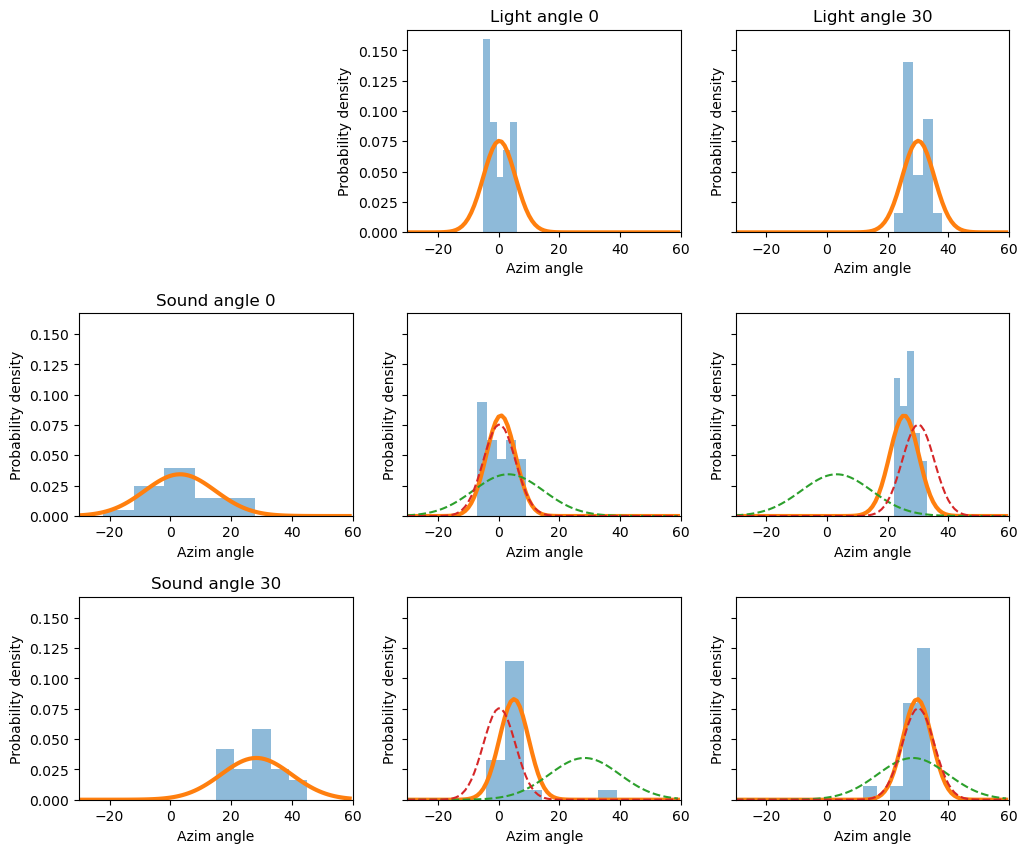

In [13]:
#The strong fusion model (MLE) is plotted only for the case of multisensory perception
fig, axs = plt.subplots(3, 3, figsize = (12, 10), sharey = True)

x_axis = np.arange(-30, 60)

for i in range(8):
  (a, b) = data.iloc[i,-3]
  axs[a, b].hist(data.iloc[i,:20], density=True, bins=bins[i], alpha=0.5)
  axs[a, b].plot(x_axis, norm.pdf(x_axis, get_loc(data.iloc[i,:], out_mle["x"]), get_scale(data.iloc[i,:], out_mle["x"])), linewidth=3)
  if not np.isnan(data.iloc[i,-1]) and not np.isnan(data.iloc[i,-2]):
    m_a = m_a0 if data.iloc[i,-2] == 0 else m_a30
    m_v = m_v0 if data.iloc[i,-1] == 0 else m_v30
    axs[a, b].plot(x_axis, norm.pdf(x_axis, m_a, s_a), linestyle='dashed')
    axs[a, b].plot(x_axis, norm.pdf(x_axis, m_v, s_v), linestyle='dashed')

for i in range(3):
  for j in range(3):
      axs[i, j].set_xlim([-30,60])
      axs[i, j].set_xlabel("Azim angle")
      axs[i, j].set_ylabel("Probability density") 

axs[0,1].set_title("Light angle 0")
axs[0,2].set_title("Light angle 30")

axs[1, 0].set_title("Sound angle 0")
axs[2,0].set_title("Sound angle 30")

axs[0,0].axis("off")
axs[0,1].yaxis.set_tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.4)
plt.show()

### BCI

In [14]:
def loss_bci(data, estimate):
  loss = 0
  m_a0, m_a30, m_v0, m_v30, s_a, s_v, est = estimate
  for i, row in data.iterrows():
    scale = get_scale(row, estimate[:-1])
    loc = get_loc(row, estimate[:-1])
    if np.isnan(row.iloc[-2]) or np.isnan(row.iloc[-1]):
      P_c = 0 #if its only one stimulus then for sure the probability of the strong fusion estimate is zero 
    else:
      P_c = np.exp(est) / (1 + np.exp(est)) #softmax to constrain the probability between zero and one 
    for j in range(20): 
      N_1 = norm.pdf(row.iloc[j], loc=loc, scale=scale) 
      if np.isnan(row.iloc[-2]): #if the audio is nan, take only the visual stimulus
        if row.iloc[-1] == 0:
          N_2 = norm.pdf(row.iloc[j], loc=m_v0, scale=s_v)
        else:
          N_2 = norm.pdf(row.iloc[j], loc=m_v30, scale=s_v)
      else: #if the audio is not nan, take only the audio (pointing a laser towards the audio)
        if row.iloc[-2] == 0: 
          N_2 = norm.pdf(row.iloc[j], loc=m_a0, scale=s_a)
        else:
          N_2 = norm.pdf(row.iloc[j], loc=m_a30, scale=s_a)
      loss -= np.log(N_1 * P_c + N_2 * (1 - P_c))
  return loss

In [15]:
initial_guess = [0, 30, 0, 30, 5, 5, 0]
out_bci = minimize(lambda x: loss_bci(data, x), initial_guess, method="Powell", options={"maxiter":2000})

In [16]:
out_bci

   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ],
       [ 0.56320071, -0.77318783, -0.048193  ,  0.09395262, -0.65857329,
        -0.05824602,  0.05646486]])
     fun: 485.44477450452035
 message: 'Optimization terminated successfully.'
    nfev: 536
     nit: 7
  status: 0
 success: True
       x: array([ 2.49410929, 28.44846283,  0.14032966, 29.9485702 , 10.07061996,
        3.77581469,

In [17]:
out_bci["fun"]

485.44477450452035

In [18]:
m_a0, m_a30, m_v0, m_v30, s_a, s_v, est = out_bci["x"]
P_c = np.exp(est) / (1 + np.exp(est))
out_bci["x"]

array([ 2.49410929, 28.44846283,  0.14032966, 29.9485702 , 10.07061996,
        3.77581469,  3.10275299])

In [19]:
P_c

0.9570061606010142

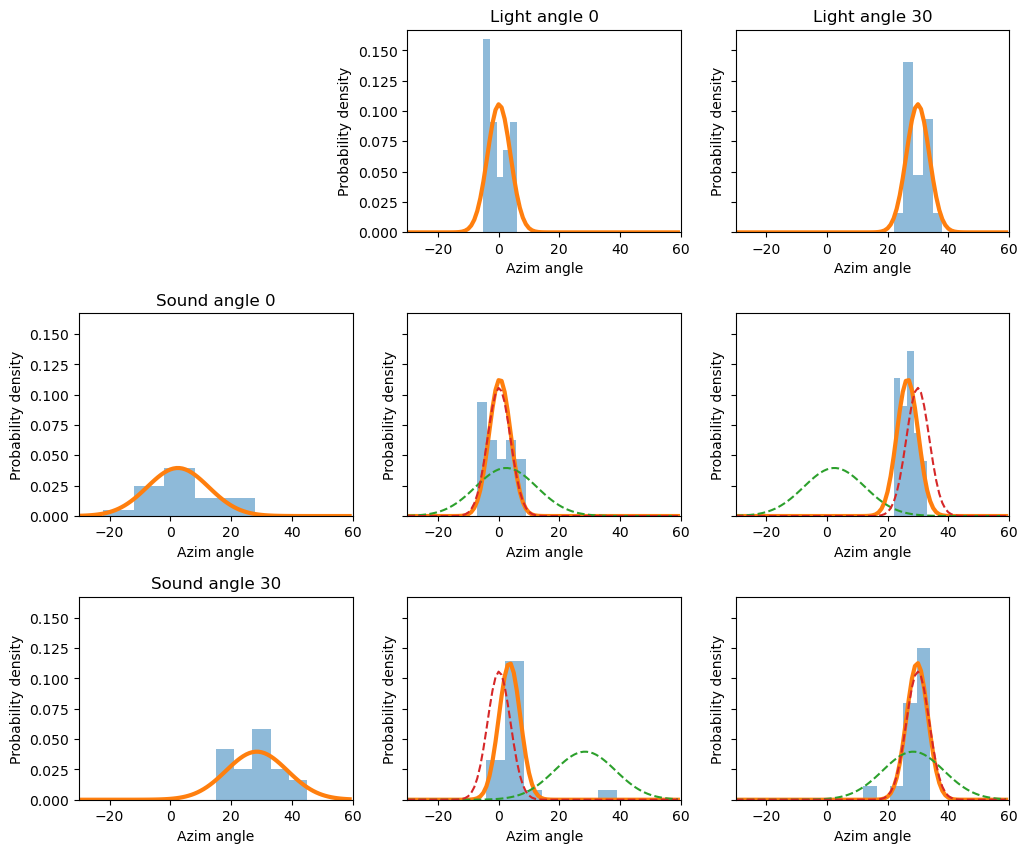

In [20]:
fig, axs = plt.subplots(3, 3, figsize = (12, 10), sharey = True)

x_axis = np.arange(-30, 60)

for i in range(8):
  (a, b) = data.iloc[i,-3]
  axs[a, b].hist(data.iloc[i,:20], density=True, bins=bins[i], alpha=0.5)
  if not np.isnan(data.iloc[i,-1]) and not np.isnan(data.iloc[i,-2]):
    m_a = m_a0 if data.iloc[i,-2] == 0 else m_a30
    m_v = m_v0 if data.iloc[i,-1] == 0 else m_v30
    axs[a, b].plot(x_axis, norm.pdf(x_axis, get_loc(data.iloc[i,:], out_bci["x"][:-1]), get_scale(data.iloc[i,:], out_bci["x"][:-1])) * P_c +
                          norm.pdf(x_axis, loc=m_a0, scale=s_a) * (1 - P_c), linewidth=3)
    axs[a, b].plot(x_axis, norm.pdf(x_axis, m_a, s_a), linestyle='dashed')
    axs[a, b].plot(x_axis, norm.pdf(x_axis, m_v, s_v), linestyle='dashed')
  else:
    axs[a, b].plot(x_axis, norm.pdf(x_axis, get_loc(data.iloc[i,:], out_bci["x"][:-1]), get_scale(data.iloc[i,:], out_bci["x"][:-1])), linewidth=3)

for i in range(3):
  for j in range(3):
      axs[i, j].set_xlim([-30,60])
      axs[i, j].set_xlabel("Azim angle")
      axs[i, j].set_ylabel("Probability density") 

axs[0,1].set_title("Light angle 0")
axs[0,2].set_title("Light angle 30")

axs[1, 0].set_title("Sound angle 0")
axs[2,0].set_title("Sound angle 30")

axs[0,0].axis("off")
axs[0,1].yaxis.set_tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.4)
plt.show()

## Cross-validation

### MLE

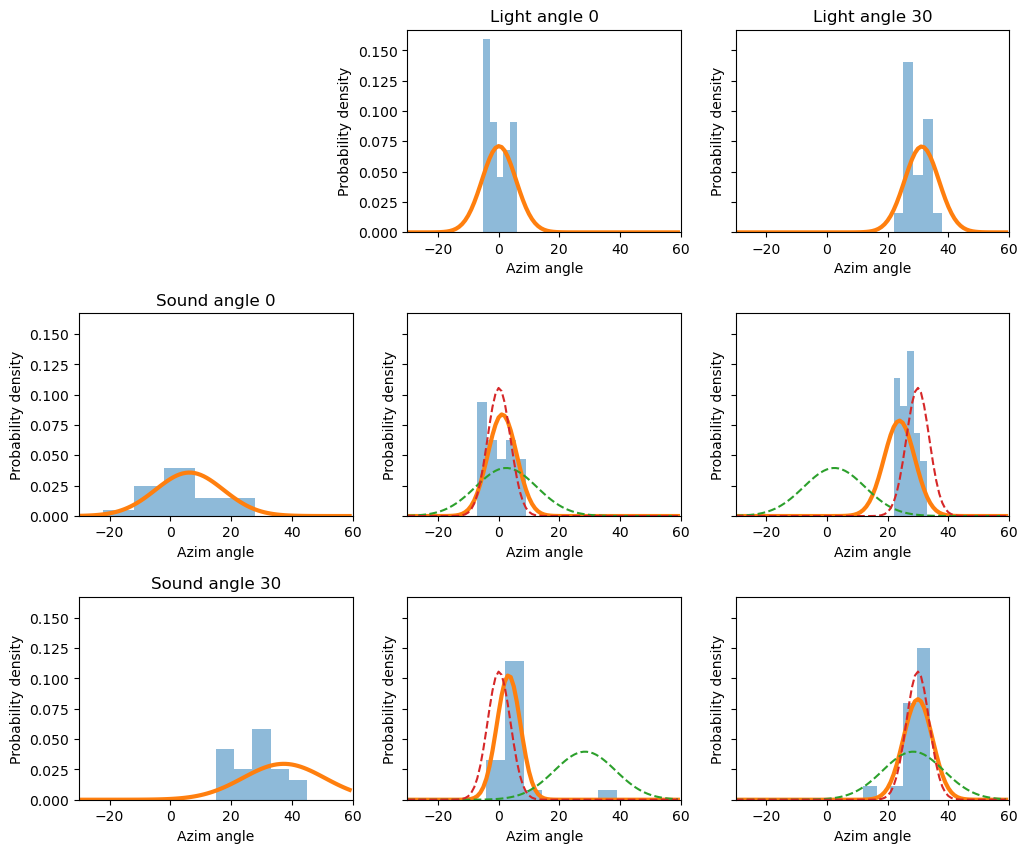

In [21]:
fig, axs = plt.subplots(3, 3, figsize = (12, 10), sharey = True)

x_axis = np.arange(-30, 60)

val_loss = []
for i in range(8): #drop one row at the time
  train_data = data.drop(axis=0, index=i)
  val_data = data.iloc[[i]] #returns a df with only one row of the dataframe at index i

  initial_guess = [0, 30, 0, 30, 5, 5]
  out = minimize(lambda x: loss_mle(train_data, x), initial_guess, method="Powell")
  val_loss.append(loss_mle(val_data, out["x"])) #use the parameters calculated above on the training set to estimate the loss on the validation set 

  (a, b) = val_data["position"][i]
  axs[a, b].hist(val_data.iloc[0,:20], density = True, bins = bins[i], alpha=0.5)
  axs[a, b].plot(x_axis, norm.pdf(x_axis, get_loc(val_data.iloc[0], out["x"]), get_scale(val_data.iloc[0], out["x"])), linewidth=3)
  if not np.isnan(val_data.iloc[0,-1]) and not np.isnan(val_data.iloc[0,-2]):
    m_a = m_a0 if val_data.iloc[0,-2] == 0 else m_a30
    m_v = m_v0 if val_data.iloc[0,-1] == 0 else m_v30
    axs[a, b].plot(x_axis, norm.pdf(x_axis, m_a, s_a), linestyle='dashed')
    axs[a, b].plot(x_axis, norm.pdf(x_axis, m_v, s_v), linestyle='dashed')


for i in range(3):
  for j in range(3):
      axs[i, j].set_xlim([-30,60])
      axs[i, j].set_xlabel("Azim angle")
      axs[i, j].set_ylabel("Probability density") 

axs[0,1].set_title("Light angle 0")
axs[0,2].set_title("Light angle 30")

axs[1, 0].set_title("Sound angle 0")
axs[2,0].set_title("Sound angle 30")

axs[0,0].axis("off")
axs[0,1].yaxis.set_tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.4)
plt.show()

In [22]:
val_loss

[79.25042594102136,
 79.50425346735574,
 56.43418793232061,
 58.547281280288544,
 61.19489721561865,
 57.11442603620149,
 94.19375920730685,
 59.89748350682507]

In [23]:
cross_val_loss = sum(val_loss)
cross_val_loss

546.1367145869384

### BCI

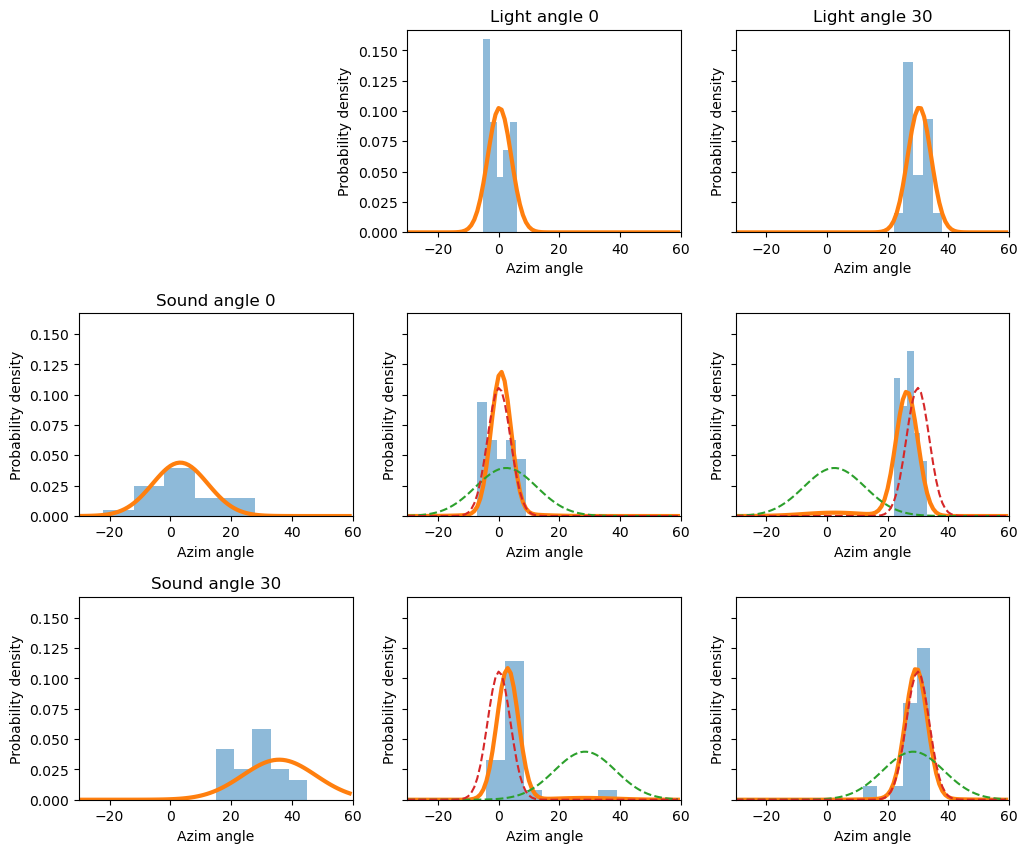

In [24]:
fig, axs = plt.subplots(3, 3, figsize = (12, 10), sharey = True)

x_axis = np.arange(-30, 60)

val_loss = []
for i in range(8):
  train_data = data.drop(axis=0, index=i)
  val_data = data.iloc[[i]]

  initial_guess = [0, 30, 0, 30, 5, 5, 0]
  out = minimize(lambda x: loss_bci(train_data, x), initial_guess, method="Powell")
  est = out["x"][-1]
  P_c = np.exp(est) / (1 + np.exp(est))
  val_loss.append(loss_bci(val_data, out["x"]))

  (a, b) = val_data["position"][i]
  axs[a, b].hist(val_data.iloc[0,:20], density = True, bins = bins[i], alpha=0.5)
  if not np.isnan(val_data.iloc[0,-1]) and not np.isnan(val_data.iloc[0,-2]):
    m_a = m_a0 if val_data.iloc[0,-2] == 0 else m_a30
    m_v = m_v0 if val_data.iloc[0,-1] == 0 else m_v30
    axs[a, b].plot(x_axis, norm.pdf(x_axis, get_loc(val_data.iloc[0,:], out["x"][:-1]), get_scale(val_data.iloc[0,:], out["x"][:-1])) * P_c +
                      norm.pdf(x_axis, loc=m_a, scale=s_a) * (1 - P_c), linewidth=3)
    axs[a, b].plot(x_axis, norm.pdf(x_axis, m_a, s_a), linestyle='dashed')
    axs[a, b].plot(x_axis, norm.pdf(x_axis, m_v, s_v), linestyle='dashed')
  else:
    axs[a, b].plot(x_axis, norm.pdf(x_axis, get_loc(val_data.iloc[0,:], out["x"][:-1]), get_scale(val_data.iloc[0,:], out["x"][:-1])), linewidth=3)


for i in range(3):
  for j in range(3):
      axs[i, j].set_xlim([-30,60])
      axs[i, j].set_xlabel("Azim angle")
      axs[i, j].set_ylabel("Probability density") 

axs[0,1].set_title("Light angle 0")
axs[0,2].set_title("Light angle 30")

axs[1, 0].set_title("Sound angle 0")
axs[2,0].set_title("Sound angle 30")

axs[0,0].axis("off")
axs[0,1].yaxis.set_tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.4)
plt.show()

In [25]:
val_loss

[80.13174136369544,
 77.69127455312348,
 52.998429894056244,
 55.631412947302145,
 65.70355660857227,
 52.077593362435614,
 57.63653395940758,
 56.357430262106355]

In [26]:
cross_val_loss = sum(val_loss)
cross_val_loss

498.2279729506991

# Part 2 - Early MLE

In [27]:
data = [pd.read_csv(f"C:/Users/difra/Desktop/cognitive/Homework3pt2DataCSV{i}.txt", sep = "  ", header= None, engine = 'python') for i in range(1,6)]
data[1]

,0,1,2,3,4
0,1.0,3.0,11.0,24.0,24.0
1,0.0,19.0,24.0,24.0,24.0
2,0.0,0.0,0.0,2.0,9.0
3,3.0,8.0,13.0,21.0,24.0
4,8.0,18.0,24.0,24.0,24.0
5,19.0,23.0,24.0,24.0,24.0
6,21.0,24.0,24.0,24.0,24.0


In [28]:
(np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0))

array([[1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5]])

In [29]:
def loss_mle_early(data, mask, estimate):
  c_a, c_v, s_a, s_v = estimate
  loss = 0

  # audio only
  loss -= np.log(binom.pmf(data.iloc[0,:], 24, norm.cdf((np.arange(1,6)-c_a)/s_a))).sum(where=mask[0,:]) #binomial likelihood because we have two categories

  # visual only
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, norm.cdf((np.arange(1,6)-c_v)/s_v))).sum(where=mask[1,:])

  # integrated
  w_a = (s_v ** 2) / (s_a ** 2 + s_v **2)
  m_a_tilde = (np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0)) - c_a 
  m_v_tilde = (np.repeat(np.arange(1,6).reshape(5,1), 5, axis=1)) - c_v
  m_tilde = w_a * m_a_tilde + (1-w_a) * m_v_tilde
  s_av = np.sqrt((s_v ** 2) * (s_a ** 2) / (s_a ** 2 + s_v **2))
  p = norm.cdf(m_tilde/s_av)
  loss -= np.log(binom.pmf(data.iloc[2:,:], 24, p)).sum(where=mask[2:,:])

  return loss

In [30]:
def get_prob_mle(estimate):
    c_a, c_v, s_a, s_v = estimate
    response_prob = np.zeros((7,5))
    # audio
    response_prob[0,:] = norm.cdf((np.arange(1,6)-c_a)/s_a)
    # video
    response_prob[1,:] = norm.cdf((np.arange(1,6)-c_v)/s_v)
    # itegrated
    w_a = (s_v ** 2) / (s_a ** 2 + s_v **2)
    m_a_tilde = (np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0)) - c_a
    m_v_tilde = (np.repeat(np.arange(1,6).reshape(5,1), 5, axis=1)) - c_v
    m_tilde = w_a * m_a_tilde + (1-w_a) * m_v_tilde
    s_av = np.sqrt((s_v ** 2) * (s_a ** 2) / (s_a ** 2 + s_v **2))
    response_prob[2:,:] = norm.cdf(m_tilde/s_av) 

    return response_prob #prob of a d response given each stimulus

In [31]:
parameters_mle = pd.DataFrame(np.zeros((5,4)), columns=["c_a", "c_v", "sigma_a", "sigma_v"])
losses = pd.DataFrame(np.zeros((5,2)), columns=["MLE", "BCI"])
response_prob_mle = np.zeros((5,7,5))
for i, d in enumerate(data):
  x_0 = [2, 2, 1, 1]
  out_mle_e = minimize(lambda x: loss_mle_early(d, np.full((7,5), True), x), x_0, method="Powell") #here the mask is simply a matrix of the same dimension of the dataframe and of all true
  response_prob_mle[i,:,:] = get_prob_mle(out_mle_e["x"])
  parameters_mle.iloc[i,:] = out_mle_e["x"]
  losses.iloc[i,0] = out_mle_e["fun"]

C:\Users\difra\AppData\Local\Temp\ipykernel_28008\260598611.py:18: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(binom.pmf(data.iloc[2:,:], 24, p)).sum(where=mask[2:,:])
c:\Users\difra\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\260598611.py:9: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, norm.cdf((np.arange(1,6)-c_v)/s_v))).sum(where=mask[1,:])
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\260598611.py:6: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(binom.pmf(data.iloc[0,:], 24, norm.cdf((np.arange(1,6)-c_a)/s_a))).sum(where=mask[0,:]) #binomial likelihood because we have two categories
c:\Users\difra\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boo

In [32]:
def loss_bci_early(data, mask, estimate):
  c_a, c_v, s_a, s_v, est = estimate
  prob = 1 / (1 + np.exp(-est)) #sigmoid
  loss = 0

  # audio only
  loss -= np.log(binom.pmf(data.iloc[0,:], 24, norm.cdf((np.arange(1,6)-c_a)/s_a))).sum(where=mask[0,:])

  # visual only
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, norm.cdf((np.arange(1,6)-c_v)/s_v))).sum(where=mask[1,:])

  # integrated
  w_a = (s_v ** 2) / (s_a ** 2 + s_v **2)
  m_a_tilde = (np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0)) - c_a
  m_v_tilde = (np.repeat(np.arange(1,6).reshape(5,1), 5, axis=1)) - c_v
  m_tilde = w_a * m_a_tilde + (1-w_a) * m_v_tilde
  s_av = np.sqrt((s_v ** 2) * (s_a ** 2) / (s_a ** 2 + s_v **2))
  p = norm.cdf(m_tilde/s_av)
  p_integr = p
  p_aud = norm.cdf((np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0)-c_a)/s_a)
  loss -= np.log(binom.pmf(data.iloc[2:,:], 24, prob * p_integr + (1-prob) * p_aud)).sum(where=mask[2:,:])

  return loss

In [33]:
def get_prob_bci(estimate):
    c_a, c_v, s_a, s_v, est = estimate
    prob = 1 / (1 + np.exp(-est))
    
    response_prob = np.zeros((7,5))
    # audio
    response_prob[0,:] = norm.cdf((np.arange(1,6)-c_a)/s_a)
    # video
    response_prob[1,:] = norm.cdf((np.arange(1,6)-c_v)/s_v)
    # itegrated
    w_a = (s_v ** 2) / (s_a ** 2 + s_v **2)
    m_a_tilde = (np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0)) - c_a
    m_v_tilde = (np.repeat(np.arange(1,6).reshape(5,1), 5, axis=1)) - c_v
    m_tilde = w_a * m_a_tilde + (1-w_a) * m_v_tilde
    s_av = np.sqrt((s_v ** 2) * (s_a ** 2) / (s_a ** 2 + s_v **2))
    p_1 = norm.cdf(m_tilde/s_av)
    p_2 = norm.cdf((np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0)-c_a)/s_a)
    response_prob[2:,:] = p_1 * prob + p_2 * (1-prob)

    return response_prob #return prob of a d response given each stimulus

In [34]:
parameters_bci = pd.DataFrame(np.zeros((5,5)), columns=["c_a", "c_v", "sigma_a", "sigma_v", "P(N_c=1)"])
response_prob_bci = np.zeros((5,7,5))
for i, d in enumerate(data):
  x_0 = [2, 2, 1, 1, 0]
  out_bci_e = minimize(lambda x: loss_bci_early(d, np.full((7,5), True), x), x_0)
  response_prob_bci[i,:,:] = get_prob_bci(out_bci_e["x"])
  parameters_bci.iloc[i,:] = out_bci_e["x"]
  parameters_bci.iloc[i,-1] = 1 / (1 + np.exp(-out_bci_e["x"][-1]))
  losses.iloc[i,1] = out_bci_e["fun"]

C:\Users\difra\AppData\Local\Temp\ipykernel_28008\4263236595.py:10: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, norm.cdf((np.arange(1,6)-c_v)/s_v))).sum(where=mask[1,:])
c:\Users\difra\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\4263236595.py:10: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, norm.cdf((np.arange(1,6)-c_v)/s_v))).sum(where=mask[1,:])
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\4263236595.py:10: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, norm.cdf((np.arange(1,6)-c_v)/s_v))).sum(where=mask[1,:])
c:\Users\difra\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\difra\AppData\Local\Temp\i

In [35]:
print("parameters_mle")
print(parameters_mle.to_latex())
print("parameters_bci")
print(parameters_bci.to_latex())
print("losses")
print(losses.to_latex())

parameters_mle
\begin{tabular}{lrrrr}
\toprule
{} &       c\_a &       c\_v &   sigma\_a &   sigma\_v \\
\midrule
0 &  3.299669 &  1.864448 &  0.901738 &  0.874722 \\
1 &  3.019710 &  1.985261 &  0.760658 &  0.586375 \\
2 &  2.907404 &  2.042792 &  0.908565 &  1.133321 \\
3 &  3.358007 &  3.106648 &  0.695439 &  1.138731 \\
4 &  3.325640 &  2.066205 &  0.588604 &  0.929368 \\
\bottomrule
\end{tabular}

parameters_bci
\begin{tabular}{lrrrrr}
\toprule
{} &       c\_a &       c\_v &   sigma\_a &   sigma\_v &  P(N\_c=1) \\
\midrule
0 &  3.141075 &  1.967464 &  0.493790 &  0.104536 &  0.629537 \\
1 &  2.941945 &  1.970841 &  0.679486 &  0.459718 &  0.946572 \\
2 &  2.890086 &  2.039971 &  0.880565 &  1.005703 &  0.857661 \\
3 &  3.377076 &  3.074208 &  0.676655 &  0.980258 &  0.741596 \\
4 &  3.306801 &  2.066392 &  0.560276 &  0.816124 &  0.822026 \\
\bottomrule
\end{tabular}

losses
\begin{tabular}{lrr}
\toprule
{} &        MLE &        BCI \\
\midrule
0 &  72.806945 &  57.332477 \\
1 &  

C:\Users\difra\AppData\Local\Temp\ipykernel_28008\3697354186.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameters_mle.to_latex())
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\3697354186.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameters_bci.to_latex())
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\3697354186.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_lat

## Cross validation

### MLE

In [36]:
cv_val_loss = pd.DataFrame(np.zeros((5,2)), columns=["MLE", "BCI"])
response_prob_mle_cv = np.zeros((5,7,5))

for i, d in enumerate(data):
  val_loss = 0
  for j in range(35):
    mask = np.full((7,5), True)
    mask[j//5, j%5] = False
    x_0 = [2, 2, 1, 1]
    out_mle_e = minimize(lambda x: loss_mle_early(d, mask, x), x_0)
    val_loss += loss_mle_early(d, ~mask, out_mle_e["x"])
    response_prob_mle_cv[i, j//5, j%5] = get_prob_mle(out_mle_e["x"])[j//5, j%5]
  cv_val_loss.iloc[i,0] = val_loss

C:\Users\difra\AppData\Local\Temp\ipykernel_28008\260598611.py:6: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(binom.pmf(data.iloc[0,:], 24, norm.cdf((np.arange(1,6)-c_a)/s_a))).sum(where=mask[0,:]) #binomial likelihood because we have two categories
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\260598611.py:18: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(binom.pmf(data.iloc[2:,:], 24, p)).sum(where=mask[2:,:])
c:\Users\difra\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\260598611.py:6: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(binom.pmf(data.iloc[0,:], 24, norm.cdf((np.arange(1,6)-c_a)/s_a))).sum(where=mask[0,:]) #binomial likelihood because we have two categories
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\260598611.py:18: RuntimeWarning: divide by zero encountered in lo

### BCI

In [37]:
response_prob_bci_cv = np.zeros((5,7,5))

for i, d in enumerate(data):
  val_loss = 0
  for j in range(35):
    mask = np.full((7,5), True)
    mask[j//5, j%5] = False
    x_0 = [2, 2, 1, 1, 0]
    out_bci_e = minimize(lambda x: loss_bci_early(d, mask, x), x_0)
    val_loss += loss_bci_early(d, ~mask, out_bci_e["x"])
    response_prob_bci_cv[i, j//5, j%5] = get_prob_bci(out_bci_e["x"])[j//5, j%5]
  cv_val_loss.iloc[i,1] = val_loss


C:\Users\difra\AppData\Local\Temp\ipykernel_28008\4263236595.py:10: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, norm.cdf((np.arange(1,6)-c_v)/s_v))).sum(where=mask[1,:])
c:\Users\difra\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\4263236595.py:10: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, norm.cdf((np.arange(1,6)-c_v)/s_v))).sum(where=mask[1,:])
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\4263236595.py:10: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, norm.cdf((np.arange(1,6)-c_v)/s_v))).sum(where=mask[1,:])
c:\Users\difra\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\difra\AppData\Local\Temp\i

In [38]:
print("cv_val_loss")
print(cv_val_loss.to_latex())


cv_val_loss
\begin{tabular}{lrr}
\toprule
{} &        MLE &        BCI \\
\midrule
0 &  89.296769 &  92.245413 \\
1 &  73.010580 &  79.556374 \\
2 &  80.734665 &  84.045294 \\
3 &  79.651115 &  92.336673 \\
4 &  64.844483 &  67.380094 \\
\bottomrule
\end{tabular}



C:\Users\difra\AppData\Local\Temp\ipykernel_28008\2772450532.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cv_val_loss.to_latex())


## Scatter

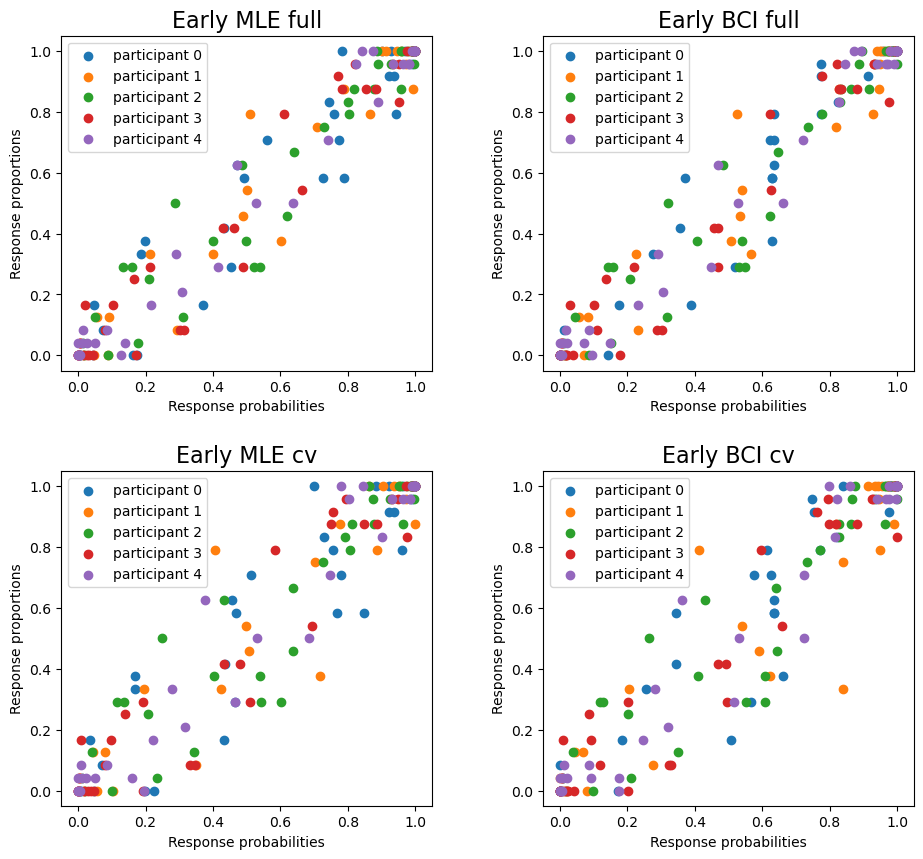

In [39]:
fig, ax = plt.subplots(2,2, figsize=(11,10))
for i in range(5):
    ax[0,0].scatter(response_prob_mle[i,:,:].flatten(), data[i].to_numpy().flatten()/24, label=f"participant {i}")
ax[0,0].set_title("Early MLE full", size=16)
for i in range(5):
    ax[0,1].scatter(response_prob_bci[i,:,:].flatten(), data[i].to_numpy().flatten()/24, label=f"participant {i}")
ax[0,1].set_title("Early BCI full", size=16)
for i in range(5):
    ax[1,0].scatter(response_prob_mle_cv[i,:,:].flatten(), data[i].to_numpy().flatten()/24, label=f"participant {i}")
ax[1,0].set_title("Early MLE cv", size=16)
for i in range(5):
    ax[1,1].scatter(response_prob_bci_cv[i,:,:].flatten(), data[i].to_numpy().flatten()/24, label=f"participant {i}")
ax[1,1].set_title("Early BCI cv", size=16)
for a in ax.flatten():
    a.set_xlabel("Response probabilities")
    a.set_ylabel("Response proportions")
    a.legend()
plt.subplots_adjust(hspace = 0.3, wspace=0.3)
plt.show()

# Part 3 - Strong fusion probability matching model

In [40]:
EPSILON = 1e-15

In [41]:
data = [pd.read_csv(f"Homework3pt2DataCSV{i}.txt", sep = "  ", header= None, engine = 'python') for i in range(1,6)]
data[1]

,0,1,2,3,4
0,1.0,3.0,11.0,24.0,24.0
1,0.0,19.0,24.0,24.0,24.0
2,0.0,0.0,0.0,2.0,9.0
3,3.0,8.0,13.0,21.0,24.0
4,8.0,18.0,24.0,24.0,24.0
5,19.0,23.0,24.0,24.0,24.0
6,21.0,24.0,24.0,24.0,24.0


In [42]:
def loss_matching(data, mask, estimate):
  P_a = 1 / (1 + np.exp(-estimate[:5]))
  P_v = 1 / (1 + np.exp(-estimate[5:]))
  #z_a_0, z_a_1, z_a_2, z_a_3, z_a_4, z_v_0, z_v_1, z_v_2, z_v_3, z_v_4 = estimate
  loss = 0

  # audio only
  loss -= np.log(binom.pmf(data.iloc[0,:], 24, P_a) + EPSILON).sum(where=mask[0,:])

  # visual only
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, P_v) + EPSILON).sum(where=mask[1,:])

  # integrated
  num = np.repeat(P_v, 5).reshape((5,5)) * np.repeat(P_a, 5).reshape((5,5)).T
  den = num + np.repeat(1-P_v, 5).reshape((5,5)) * np.repeat(1-P_a, 5).reshape((5,5)).T #(1-P_v) represents the other probability for b
  p = num / den
  loss -= np.log(binom.pmf(data.iloc[2:,:], 24, p) + EPSILON).sum(where=mask[2:,:])

  return loss

In [43]:
def get_prob_matching(estimate):
    P_a = 1 / (1 + np.exp(-estimate[:5]))
    P_v = 1 / (1 + np.exp(-estimate[5:]))
    response_prob = np.zeros((7,5))
    # audio
    response_prob[0,:] = P_a
    # video
    response_prob[1,:] = P_v
    # itegrated
    num = np.repeat(P_v, 5).reshape((5,5)) * np.repeat(P_a, 5).reshape((5,5)).T
    den = num + np.repeat(1-P_v, 5).reshape((5,5)) * np.repeat(1-P_a, 5).reshape((5,5)).T
    response_prob[2:,:] = num / den

    return response_prob

In [44]:
parameters_matching = pd.DataFrame(np.zeros((5,10)), columns=[f"P_{s}_{i}" for s in ["a", "v"] for i in range(1,6)])
losses = pd.DataFrame(np.zeros((5,2)), columns=["Matching", "BCI"])
response_prob_matching = np.zeros((5,7,5))
for i, d in enumerate(data):
  x_0 = np.zeros(10)
  out_matching = minimize(lambda x: loss_matching(d, np.full((7,5), True), x), x_0, method="Powell")
  response_prob_matching[i,:,:] = get_prob_matching(out_matching["x"])
  parameters_matching.iloc[i,:] = np.concatenate([response_prob_matching[i,0,:], response_prob_matching[i,1,:]])
  losses.iloc[i,0] = out_matching["fun"]

In [45]:
def loss_matching_bci(data, mask, estimate):
  P_a = 1 / (1 + np.exp(-estimate[:5]))
  P_v = 1 / (1 + np.exp(-estimate[5:-1]))
  prob = 1 / (1 + np.exp(-estimate[-1]))
  
  loss = 0

  # audio only
  loss -= np.log(binom.pmf(data.iloc[0,:], 24, P_a) + EPSILON).sum(where=mask[0,:])

  # visual only
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, P_v) + EPSILON).sum(where=mask[1,:])

  # integrated
  num = np.repeat(P_v, 5).reshape((5,5)) * np.repeat(P_a, 5).reshape((5,5)).T
  den = num + np.repeat(1-P_v, 5).reshape((5,5)) * np.repeat(1-P_a, 5).reshape((5,5)).T
  p = num / den
  loss -= np.log(binom.pmf(data.iloc[2:,:], 24, prob * p + (1-prob) * np.repeat(P_a.reshape(1,5), 5, axis=0)) + EPSILON).sum(where=mask[2:,:])

  return loss

In [46]:
def get_prob_matching_bci(estimate):
    P_a = 1 / (1 + np.exp(-estimate[:5]))
    P_v = 1 / (1 + np.exp(-estimate[5:-1]))
    prob = 1 / (1 + np.exp(-estimate[-1]))
    response_prob = np.zeros((7,5))
    # audio
    response_prob[0,:] = P_a
    # video
    response_prob[1,:] = P_v
    # itegrated
    num = np.repeat(P_v, 5).reshape((5,5)) * np.repeat(P_a, 5).reshape((5,5)).T
    den = num + np.repeat(1-P_v, 5).reshape((5,5)) * np.repeat(1-P_a, 5).reshape((5,5)).T
    p_1 = num / den
    p_2 = np.repeat(P_a.reshape(1,5), 5, axis=0)
    response_prob[2:,:] = p_1 * prob + p_2 * (1 - prob)

    return response_prob

In [47]:
parameters_matching_bci = pd.DataFrame(np.zeros((5,11)), columns=[f"P_{s}_{i}" for s in ["a", "v"] for i in range(1,6)]+["P(N_c=1)"])
response_prob_matching_bci = np.zeros((5,7,5))
for i, d in enumerate(data):
  x_0 = np.zeros(11)
  out_matching_bci = minimize(lambda x: loss_matching_bci(d, np.full((7,5), True), x), x_0, method="Powell")
  response_prob_matching_bci[i,:,:] = get_prob_matching_bci(out_matching_bci["x"])
  parameters_matching_bci.iloc[i,:-1] = np.concatenate([response_prob_matching_bci[i,0,:], response_prob_matching_bci[i,1,:]])
  parameters_matching_bci.iloc[i,-1] = 1 / (1 + np.exp(-out_matching_bci["x"][-1]))
  losses.iloc[i,1] = out_matching_bci["fun"]

In [48]:
print("parameters_matching")
print(parameters_matching.to_latex())
print("parameters_matching_bci")
print(parameters_matching_bci.to_latex())
print("losses")
print(losses.to_latex())

parameters_matching
\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &     P\_a\_1 &     P\_a\_2 &     P\_a\_3 &     P\_a\_4 &     P\_a\_5 &     P\_v\_1 &     P\_v\_2 &     P\_v\_3 &     P\_v\_4 &     P\_v\_5 \\
\midrule
0 &  0.035462 &  0.091059 &  0.178728 &  0.921327 &  0.961582 &  0.048292 &  0.699072 &  0.948316 &  0.972951 &  0.978733 \\
1 &  0.024624 &  0.138058 &  0.421441 &  0.930910 &  0.992499 &  0.004778 &  0.712422 &  0.960774 &  0.993825 &  0.997182 \\
2 &  0.066132 &  0.149539 &  0.334643 &  0.931780 &  0.995538 &  0.119385 &  0.562813 &  0.823686 &  0.914381 &  0.932035 \\
3 &  0.016274 &  0.043404 &  0.115976 &  0.905218 &  0.990280 &  0.074627 &  0.232099 &  0.422971 &  0.777077 &  0.892076 \\
4 &  0.004336 &  0.019260 &  0.196064 &  0.948679 &  0.998057 &  0.047134 &  0.603867 &  0.849242 &  0.918537 &  0.954763 \\
\bottomrule
\end{tabular}

parameters_matching_bci
\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &     P\_a\_1 &     P\_a\_2 &     P\_a\_3 &     P\_a\_4 &     P\_a\_5

C:\Users\difra\AppData\Local\Temp\ipykernel_28008\3481989418.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameters_matching.to_latex())
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\3481989418.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameters_matching_bci.to_latex())
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\3481989418.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of 

## Cross validation

### Matching

In [49]:
cv_val_loss = pd.DataFrame(np.zeros((5,2)), columns=["Matching", "BCI"])
response_prob_matching_cv = np.zeros((5,7,5))

for i, d in enumerate(data):
  val_loss = 0
  for j in range(35):
    mask = np.full((7,5), True)
    mask[j//5, j%5] = False
    x_0 = np.zeros(10)
    out_matching = minimize(lambda x: loss_matching(d, mask, x), x_0)
    val_loss += loss_matching(d, ~mask, out_matching["x"])
    response_prob_matching_cv[i, j//5, j%5] = get_prob_matching(out_matching["x"])[j//5, j%5]
  cv_val_loss.iloc[i,0] = val_loss


### BCI

In [50]:
response_prob_matching_bci_cv = np.zeros((5,7,5))

for i, d in enumerate(data):
  val_loss = []
  for j in range(35):
    mask = np.full((7,5), True)
    mask[j//5, j%5] = False
    x_0 = np.zeros(11)
    out_matching_bci = minimize(lambda x: loss_matching_bci(d, mask, x), x_0, method="Powell")
    val_loss.append(loss_matching_bci(d, ~mask, out_matching_bci["x"]))
    response_prob_matching_bci_cv[i, j//5, j%5] = get_prob_matching_bci(out_matching_bci["x"])[j//5, j%5]
  cv_val_loss.iloc[i,1] = sum(val_loss)

In [51]:
print("cv_val_loss")
print(cv_val_loss.to_latex())


cv_val_loss
\begin{tabular}{lrr}
\toprule
{} &    Matching &         BCI \\
\midrule
0 &   66.694552 &  127.302667 \\
1 &  160.322089 &  145.224078 \\
2 &   86.299592 &  109.052537 \\
3 &   57.385707 &   69.261661 \\
4 &   68.778178 &   90.647785 \\
\bottomrule
\end{tabular}



C:\Users\difra\AppData\Local\Temp\ipykernel_28008\2772450532.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cv_val_loss.to_latex())


## Scatter

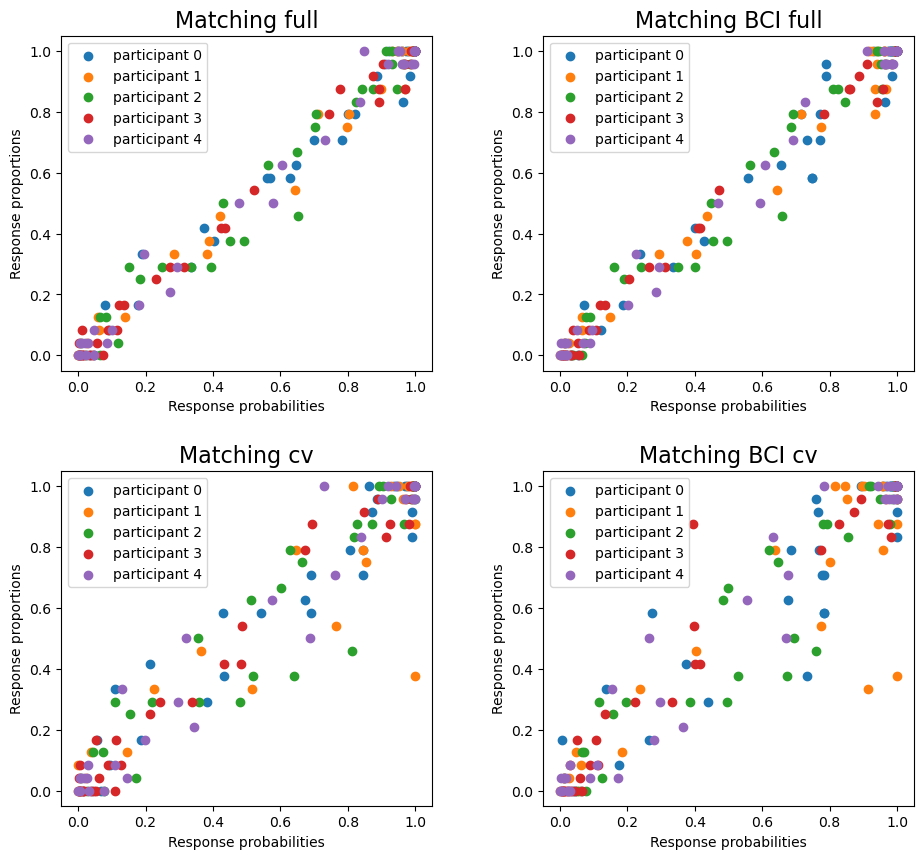

In [52]:
fig, ax = plt.subplots(2,2, figsize=(11,10))
for i in range(5):
    ax[0,0].scatter(response_prob_matching[i,:,:].flatten(), data[i].to_numpy().flatten()/24, label=f"participant {i}")
ax[0,0].set_title("Matching full", size=16)
for i in range(5):
    ax[0,1].scatter(response_prob_matching_bci[i,:,:].flatten(), data[i].to_numpy().flatten()/24, label=f"participant {i}")
ax[0,1].set_title("Matching BCI full", size=16)
for i in range(5):
    ax[1,0].scatter(response_prob_matching_cv[i,:,:].flatten(), data[i].to_numpy().flatten()/24, label=f"participant {i}")
ax[1,0].set_title("Matching cv", size=16)
for i in range(5):
    ax[1,1].scatter(response_prob_matching_bci_cv[i,:,:].flatten(), data[i].to_numpy().flatten()/24, label=f"participant {i}")
ax[1,1].set_title("Matching BCI cv", size=16)
for a in ax.flatten():
    a.set_xlabel("Response probabilities")
    a.set_ylabel("Response proportions")
    a.legend()
plt.subplots_adjust(hspace = 0.3, wspace=0.3)
plt.show()

# Part 3 - Late MLE

In [53]:
EPSILON = 1e-10

In [54]:
data = [pd.read_csv(f"Homework3pt2DataCSV{i}.txt", sep = "  ", header= None,engine='python') for i in range(1,6)]
data[1]

,0,1,2,3,4
0,1.0,3.0,11.0,24.0,24.0
1,0.0,19.0,24.0,24.0,24.0
2,0.0,0.0,0.0,2.0,9.0
3,3.0,8.0,13.0,21.0,24.0
4,8.0,18.0,24.0,24.0,24.0
5,19.0,23.0,24.0,24.0,24.0
6,21.0,24.0,24.0,24.0,24.0


In [55]:
def loss_mle_late(data, mask, estimate):
  c_a, c_v, s_a, s_v = estimate
  loss = 0

  # audio only
  loss -= np.log(binom.pmf(data.iloc[0,:], 24, norm.cdf((np.arange(1,6)-c_a)/s_a)) + EPSILON).sum(where=mask[0,:]) #like in mle_early

  # visual only
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, norm.cdf((np.arange(1,6)-c_v)/s_v)) + EPSILON).sum(where=mask[1,:]) #like in mle_early

  # integrated
  P_v = norm.cdf((np.repeat(np.arange(1,6).reshape(5,1), 5, axis=1)-c_v)/s_v) #like in mle_early
  P_a = norm.cdf((np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0)-c_a)/s_a) #like in mle_early
  num = P_v * P_a
  den = num + (1-P_v) * (1-P_a)
  p = num / den #like in prob matching
  loss -= np.log(binom.pmf(data.iloc[2:,:], 24, p) + EPSILON).sum(where=mask[2:,:]) #like in prob matching

  return loss

In [56]:
def get_prob_mle_late(estimate):
    c_a, c_v, s_a, s_v = estimate
    response_prob = np.zeros((7,5))
    # audio
    response_prob[0,:] = norm.cdf((np.arange(1,6)-c_a)/s_a)
    # video
    response_prob[1,:] = norm.cdf((np.arange(1,6)-c_v)/s_v)
    # itegrated
    P_v = norm.cdf((np.repeat(np.arange(1,6).reshape(5,1), 5, axis=1)-c_v)/s_v)
    P_a = norm.cdf((np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0)-c_a)/s_a)
    num = P_v * P_a
    den = num + (1-P_v) * (1-P_a)
    response_prob[2:,:] = num / den

    return response_prob

In [57]:
parameters_mle_late = pd.DataFrame(np.zeros((5,4)), columns=["c_a", "c_v", "sigma_a", "sigma_v"])
losses = pd.DataFrame(np.zeros((5,2)), columns=["Late MLE", "BCI"])
response_prob_mle_late = np.zeros((5,7,5))
for i, d in enumerate(data):
  x_0 = [2, 2, 1, 1]
  out_mle_l = minimize(lambda x: loss_mle_late(d, np.full((7,5), True), x), x_0, method="Powell")
  response_prob_mle_late[i,:,:] = get_prob_mle_late(out_mle_l["x"])
  parameters_mle_late.iloc[i,:] = out_mle_l["x"]
  losses.iloc[i,0] = out_mle_l["fun"]

c:\Users\difra\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


In [58]:
def loss_bci_late(data, mask, estimate):
  c_a, c_v, s_a, s_v, est = estimate
  prob = 1 / (1 + np.exp(-est))
  loss = 0

  # audio only
  loss -= np.log(binom.pmf(data.iloc[0,:], 24, norm.cdf((np.arange(1,6)-c_a)/s_a)) + EPSILON).sum(where=mask[0,:])

  # visual only
  loss -= np.log(binom.pmf(data.iloc[1,:], 24, norm.cdf((np.arange(1,6)-c_v)/s_v)) + EPSILON).sum(where=mask[1,:])

  # integrated
  P_v = norm.cdf((np.repeat(np.arange(1,6).reshape(5,1), 5, axis=1)-c_v)/s_v)
  P_a = norm.cdf((np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0)-c_a)/s_a)
  num = P_v * P_a
  den = num + (1-P_v) * (1-P_a)
  p_integr = num / den
  p_aud = norm.cdf((np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0)-c_a)/s_a)
  loss -= np.log(binom.pmf(data.iloc[2:,:], 24, prob * p_integr + (1-prob) * p_aud) + EPSILON).sum(where=mask[2:,:])

  return loss

In [59]:
def get_prob_bci_late(estimate):
    c_a, c_v, s_a, s_v, est = estimate
    prob = 1 / (1 + np.exp(-est))
    
    response_prob = np.zeros((7,5))
    # audio
    response_prob[0,:] = norm.cdf((np.arange(1,6)-c_a)/s_a)
    # video
    response_prob[1,:] = norm.cdf((np.arange(1,6)-c_v)/s_v)
    # itegrated
    P_v = norm.cdf((np.repeat(np.arange(1,6).reshape(5,1), 5, axis=1)-c_v)/s_v)
    P_a = norm.cdf((np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0)-c_a)/s_a)
    num = P_v * P_a
    den = num + (1-P_v) * (1-P_a)
    p_1 = num / den
    p_2 = norm.cdf((np.repeat(np.arange(1,6).reshape(1,5), 5, axis=0)-c_a)/s_a)
    response_prob[2:,:] = p_1 * prob + p_2 * (1-prob)

    return response_prob

In [60]:
parameters_bci_late = pd.DataFrame(np.zeros((5,5)), columns=["c_a", "c_v", "sigma_a", "sigma_v", "P(N_c=1)"])
response_prob_bci_late = np.zeros((5,7,5))
for i, d in enumerate(data):
  x_0 = [2, 2, 1, 1, 0]
  out_bci_l = minimize(lambda x: loss_bci_late(d, np.full((7,5), True), x), x_0, method="Powell")
  response_prob_bci_late[i,:,:] = get_prob_bci_late(out_bci_l["x"])
  parameters_bci_late.iloc[i,:] = out_bci_l["x"]
  parameters_bci_late.iloc[i,-1] = 1 / (1 + np.exp(-out_bci_l["x"][-1]))
  losses.iloc[i,1] = out_bci_l["fun"]

In [61]:
print("parameters_mle_late")
print(parameters_mle_late.to_latex())
print("parameters_bci_late")
print(parameters_bci_late.to_latex())
print("losses")
print(losses.to_latex())

parameters_mle_late
\begin{tabular}{lrrrr}
\toprule
{} &       c\_a &       c\_v &   sigma\_a &   sigma\_v \\
\midrule
0 &  3.220968 &  1.942695 &  1.354998 &  1.340093 \\
1 &  2.974803 &  2.083851 &  1.225741 &  0.778600 \\
2 &  2.855898 &  2.157826 &  1.119188 &  1.663346 \\
3 &  3.282299 &  3.241578 &  0.806548 &  1.798288 \\
4 &  3.295604 &  2.236080 &  0.713237 &  1.555149 \\
\bottomrule
\end{tabular}

parameters_bci_late
\begin{tabular}{lrrrrr}
\toprule
{} &       c\_a &       c\_v &   sigma\_a &   sigma\_v &  P(N\_c=1) \\
\midrule
0 &  3.116024 &  1.904686 &  0.999853 &  0.478555 &  0.712030 \\
1 &  2.935781 &  2.020491 &  0.973583 &  0.472710 &  0.933760 \\
2 &  2.789511 &  2.105462 &  1.026157 &  0.922901 &  0.618055 \\
3 &  3.344012 &  3.036311 &  0.767708 &  1.168827 &  0.584130 \\
4 &  3.233435 &  2.205779 &  0.645896 &  0.928537 &  0.551109 \\
\bottomrule
\end{tabular}

losses
\begin{tabular}{lrr}
\toprule
{} &   Late MLE &        BCI \\
\midrule
0 &  95.323443 &  69.11287

C:\Users\difra\AppData\Local\Temp\ipykernel_28008\1938074895.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameters_mle_late.to_latex())
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\1938074895.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameters_bci_late.to_latex())
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\1938074895.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Sty

## Cross validation

### MLE

In [62]:
cv_val_loss = pd.DataFrame(np.zeros((5,2)), columns=["Late MLE", "Late BCI"])
response_prob_mle_late_cv = np.zeros((5,7,5))

for i, d in enumerate(data):
  val_loss = 0
  for j in range(35):
    mask = np.full((7,5), True)
    mask[j//5, j%5] = False
    x_0 = [2, 2, 1, 1]
    out_mle_l = minimize(lambda x: loss_mle_late(d, mask, x), x_0)
    val_loss += loss_mle_late(d, ~mask, out_mle_l["x"])
    response_prob_mle_late_cv[i, j//5, j%5] = get_prob_mle_late(out_mle_l["x"])[j//5, j%5]
  cv_val_loss.iloc[i,0] = val_loss

c:\Users\difra\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
c:\Users\difra\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
c:\Users\difra\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
c:\Users\difra\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\3955590859.py:16: RuntimeWarning: invalid value encountered in divide
  p = num / den #like in prob matching
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\3955590859.py:16: RuntimeWarning: invalid value encountered in divide
  p = num / den #like in prob mat

### BCI

In [63]:
response_prob_bci_late_cv = np.zeros((5,7,5))

for i, d in enumerate(data):
  val_loss = 0
  for j in range(35):
    mask = np.full((7,5), True)
    mask[j//5, j%5] = False
    x_0 = [2, 2, 1, 1, 0]
    out_bci_l = minimize(lambda x: loss_bci_late(d, mask, x), x_0)
    val_loss += loss_bci_late(d, ~mask, out_bci_l["x"])
    response_prob_bci_late_cv[i, j//5, j%5] = get_prob_bci_late(out_bci_l["x"])[j//5, j%5]
  cv_val_loss.iloc[i,1] = val_loss

C:\Users\difra\AppData\Local\Temp\ipykernel_28008\507318917.py:17: RuntimeWarning: invalid value encountered in divide
  p_integr = num / den
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\507318917.py:17: RuntimeWarning: invalid value encountered in divide
  p_integr = num / den
c:\Users\difra\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\507318917.py:17: RuntimeWarning: invalid value encountered in divide
  p_integr = num / den
C:\Users\difra\AppData\Local\Temp\ipykernel_28008\507318917.py:17: RuntimeWarning: invalid value encountered in divide
  p_integr = num / den
c:\Users\difra\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
c:\Users\difra\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWa

In [64]:
print("cv_val_loss")
print(cv_val_loss.to_latex())


cv_val_loss
\begin{tabular}{lrr}
\toprule
{} &    Late MLE &    Late BCI \\
\midrule
0 &  120.933379 &   87.604054 \\
1 &  101.973096 &   84.818485 \\
2 &   93.348355 &   97.050584 \\
3 &   91.440140 &  103.419942 \\
4 &   84.648931 &   96.253182 \\
\bottomrule
\end{tabular}



C:\Users\difra\AppData\Local\Temp\ipykernel_28008\2772450532.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cv_val_loss.to_latex())


## Scatter

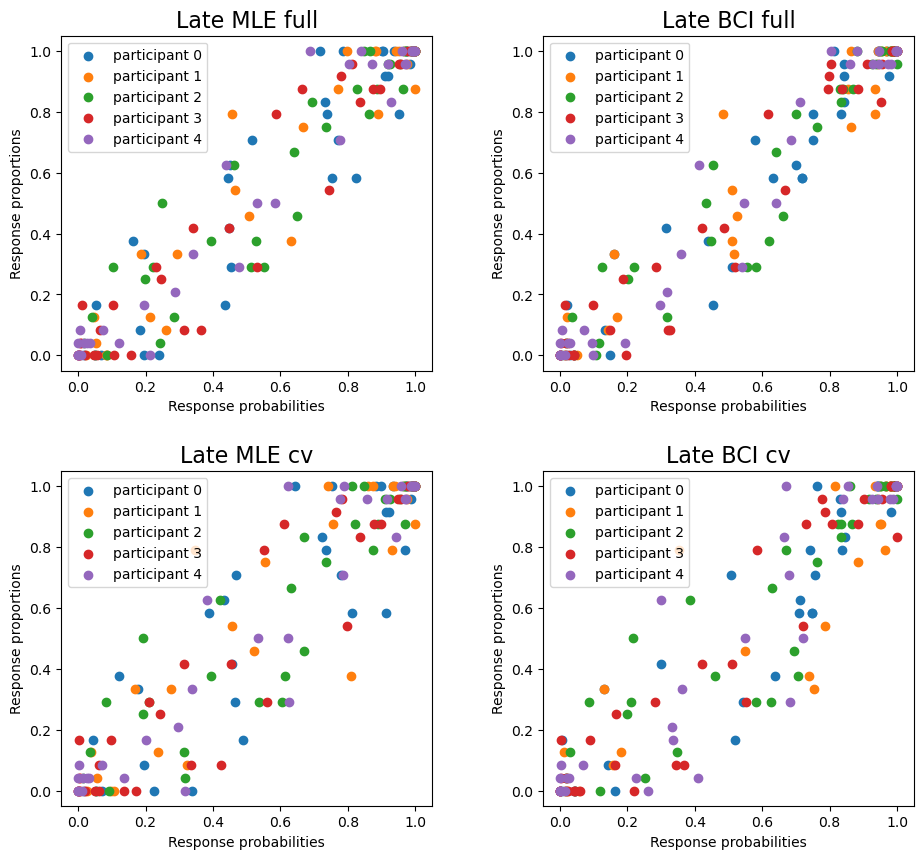

In [65]:
fig, ax = plt.subplots(2,2, figsize=(11,10))
for i in range(5):
    ax[0,0].scatter(response_prob_mle_late[i,:,:].flatten(), data[i].to_numpy().flatten()/24, label=f"participant {i}")
ax[0,0].set_title("Late MLE full", size=16)
for i in range(5):
    ax[0,1].scatter(response_prob_bci_late[i,:,:].flatten(), data[i].to_numpy().flatten()/24, label=f"participant {i}")
ax[0,1].set_title("Late BCI full", size=16)
for i in range(5):
    ax[1,0].scatter(response_prob_mle_late_cv[i,:,:].flatten(), data[i].to_numpy().flatten()/24, label=f"participant {i}")
ax[1,0].set_title("Late MLE cv", size=16)
for i in range(5):
    ax[1,1].scatter(response_prob_bci_late_cv[i,:,:].flatten(), data[i].to_numpy().flatten()/24, label=f"participant {i}")
ax[1,1].set_title("Late BCI cv", size=16)
for a in ax.flatten():
    a.set_xlabel("Response probabilities")
    a.set_ylabel("Response proportions")
    a.legend()
plt.subplots_adjust(hspace = 0.3, wspace=0.3)
plt.show()